# Single cell spatial alignment tools

SLAT (Spatially-Linked Alignment Tool), a graph-based algorithm for efficient and effective alignment of spatial slices. Adopting a graph adversarial matching strategy, SLAT is the first algorithm capable of aligning heterogenous spatial data across distinct technologies and modalities. 

We made two improvements in integrating the STT algorithm in OmicVerse:

- **Fix the running error in alignment**: We fixed some issues with the scSLAT package on pypi.
- **Added more downstream analysis**: We have expanded on the original tutorial by combining the tutorial and reproduce code given by the authors for downstream analysis.

If you found this tutorial helpful, please cite SLAT and OmicVerse: 

- Xia, CR., Cao, ZJ., Tu, XM. et al. Spatial-linked alignment tool (SLAT) for aligning heterogenous slices. Nat Commun 14, 7236 (2023). https://doi.org/10.1038/s41467-023-43105-5

In [1]:
import omicverse as ov
import os

import scanpy as sc
import numpy as np
import pandas as pd
import torch
ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.10, Tutorials: https://omicverse.readthedocs.io/


In [2]:
#import scSLAT
from omicverse.externel.scSLAT.model import load_anndatas, Cal_Spatial_Net, run_SLAT, scanpy_workflow, spatial_match
from omicverse.externel.scSLAT.viz import match_3D_multi, hist, Sankey, match_3D_celltype, Sankey
from omicverse.externel.scSLAT.metrics import region_statistics

## Preprocess Data

adata1.h5ad: E11.5 mouse embryo dataset, download from [here](https://drive.google.com/uc?export=download&id=1KkuJt6aSlKS1AJzFZjE_odypY-GINRuD)

adata2.h5ad: E12.5 mouse embryo dataset, download from [here](https://drive.google.com/uc?export=download&id=1YIiEmjGfHxcDbGn4nv2kzmTHUo3_q5hJ)

In [3]:
adata1 = sc.read_h5ad('data/E115_Stereo.h5ad')
adata2 = sc.read_h5ad('data/E125_Stereo.h5ad')

In [20]:
adata1.obs['week']='E11.5'
adata2.obs['week']='E12.5'

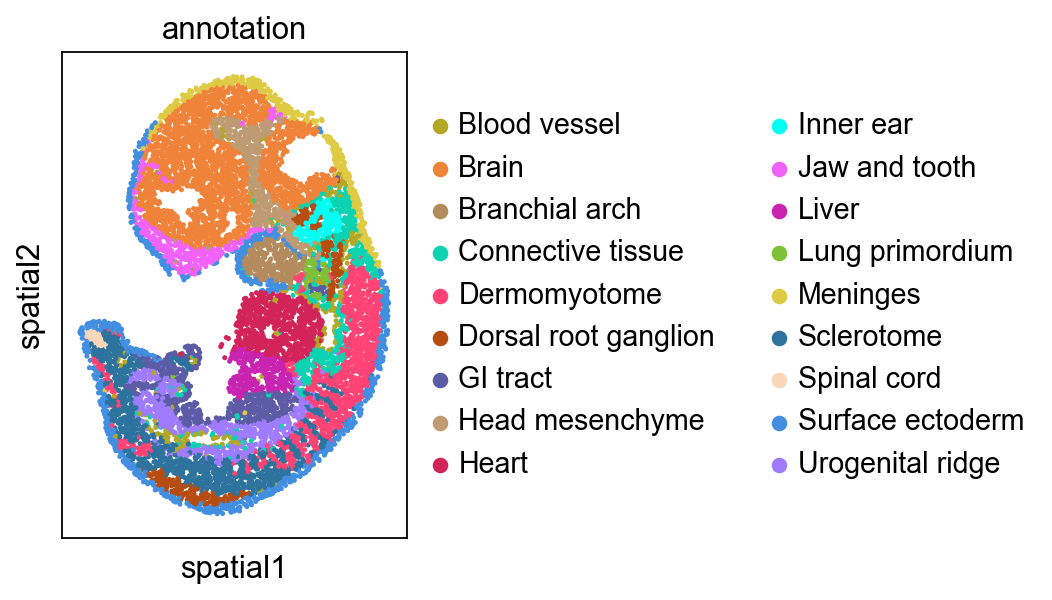

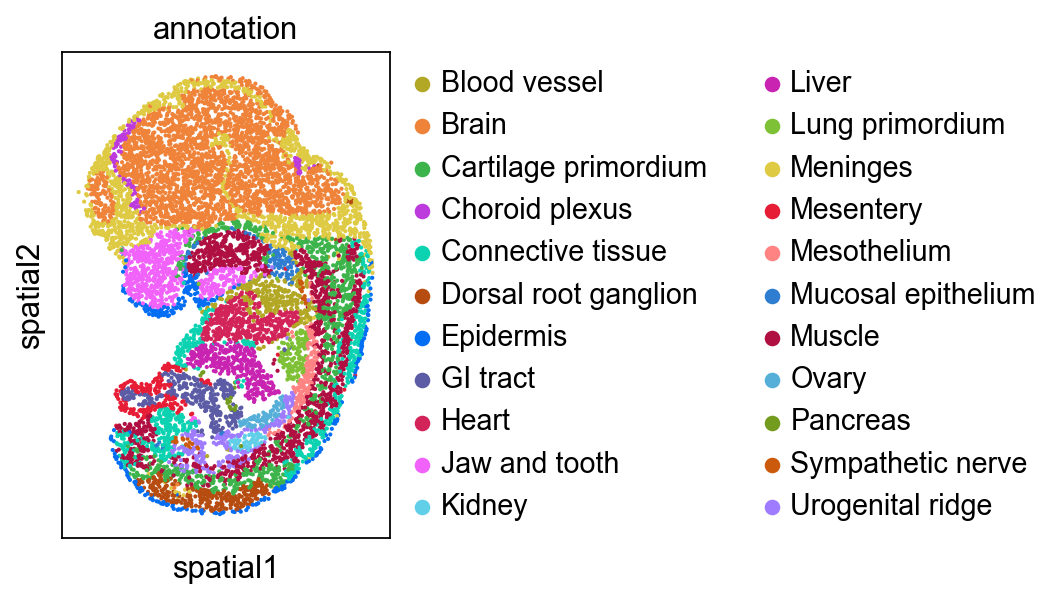

In [4]:
sc.pl.spatial(adata1, color='annotation', spot_size=3)
sc.pl.spatial(adata2, color='annotation', spot_size=3)

## Run SLAT

Then we run SLAT as usual

In [5]:
Cal_Spatial_Net(adata1, k_cutoff=20, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=20, model='KNN')
edges, features = load_anndatas([adata1, adata2], feature='DPCA', check_order=False)

Calculating spatial neighbor graph ...
The graph contains 218282 edges, 10000 cells.
21.8282 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 219259 edges, 10001 cells.
21.923707629237075 neighbors per cell on average.
Use DPCA feature to format graph
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Warning! Dual PCA is using GPU, which may lead to OUT OF GPU MEMORY in big dataset!


In [6]:
embd0, embd1, time = run_SLAT(features, edges, LGCN_layer=5)

Choose GPU:0 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 1.16


In [7]:
best, index, distance = spatial_match([embd0, embd1], reorder=False, adatas=[adata1,adata2])

In [8]:
adata1_df = pd.DataFrame({'index':range(embd0.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'celltype':adata1.obs['annotation']})
adata2_df = pd.DataFrame({'index':range(embd1.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype':adata2.obs['annotation']})
matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]
region_statistics(best_match, start=0.5, number_of_interval=10)

0.500~0.550        10          0.100%
0.550~0.600        48          0.480%
0.600~0.650       152          1.520%
0.650~0.700       536          5.359%
0.700~0.750      1091         10.909%
0.750~0.800      1635         16.348%
0.800~0.850      1903         19.028%
0.850~0.900      1760         17.598%
0.900~0.950      1984         19.838%
0.950~1.000       878          8.779%


## Visualization of alignment

dataset1: 18 cell types; dataset2: 22 cell types; 
                    Total :29 celltypes; Overlap: 11 cell types 
                    Not overlap :[['Inner ear', 'Head mesenchyme', 'Branchial arch', 'Surface ectoderm', 'Dermomyotome', 'Spinal cord', 'Sclerotome', 'Sympathetic nerve', 'Cartilage primordium', 'Epidermis', 'Pancreas', 'Mesothelium', 'Choroid plexus', 'Kidney', 'Muscle', 'Ovary', 'Mesentery', 'Mucosal epithelium']]
Subsampled 300 pairs from 10001


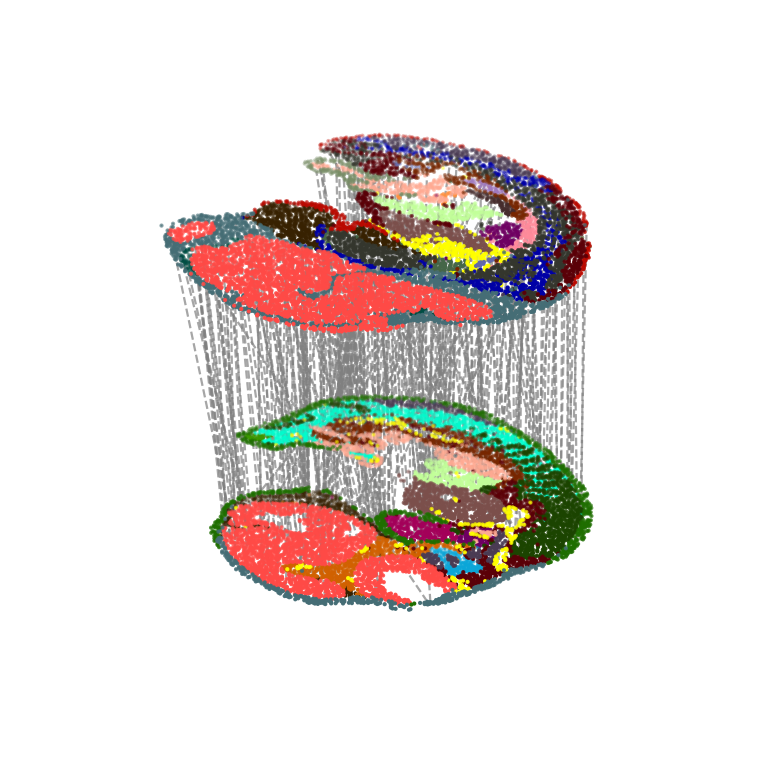

In [9]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)

multi_align.draw_3D(size=[6, 6], line_width =1, point_size=[0.8,0.8], hide_axis=True, show_error=False)

Then we check the alignment quality of the whole slide

In [10]:
adata2.obs['low_quality_index']= best_match
adata2.obs['low_quality_index'] = adata2.obs['low_quality_index'].astype(float)

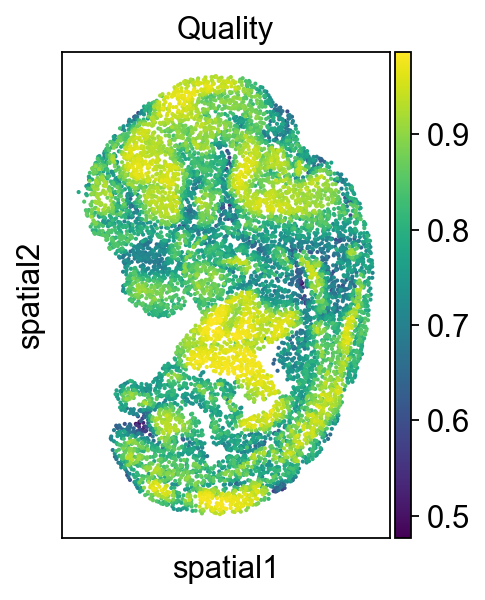

In [11]:
sc.pl.spatial(adata2, color='low_quality_index', spot_size=3, title='Quality')

We use a Sankey diagram to show the correspondence between cell types at different stages of development

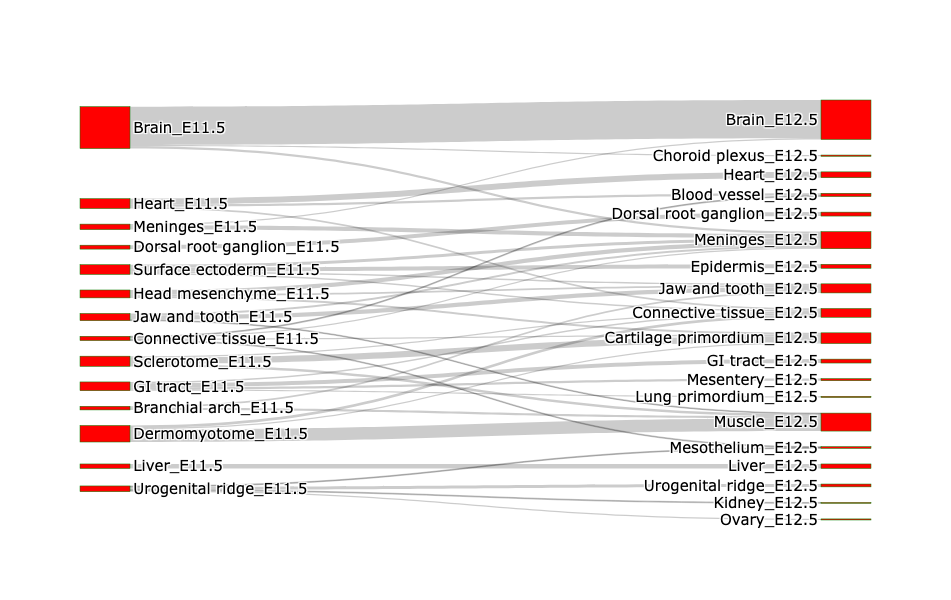

In [13]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype', 'target_celltype']).size().unstack(fill_value=0)
Sankey(matching_table, layout=[800,600], font_size=15)

## Focus on developing Kidney

We highlighted the “Kidney” cells in E12.5 and their aligned precursor cells in E11.5 in alignment results. Consistent with our biological priors, the precursors of the kidney are the mesonephros and the metanephros

Then we focus on another organ: ‘Ovary’, and found ovary only has single spatial origin. It is interesting that precursors of ovary are spatially close to the mesonephros (see Kidney part), because mammalian ovary originates from the regressed mesonephros.

dataset1: 18 cell types; dataset2: 22 cell types; 
                    Total :29 celltypes; Overlap: 11 cell types 
                    Not overlap :[['Inner ear', 'Head mesenchyme', 'Branchial arch', 'Surface ectoderm', 'Dermomyotome', 'Spinal cord', 'Sclerotome', 'Sympathetic nerve', 'Cartilage primordium', 'Epidermis', 'Pancreas', 'Mesothelium', 'Choroid plexus', 'Kidney', 'Muscle', 'Ovary', 'Mesentery', 'Mucosal epithelium']]
Subsampled 10000 pairs from 10001


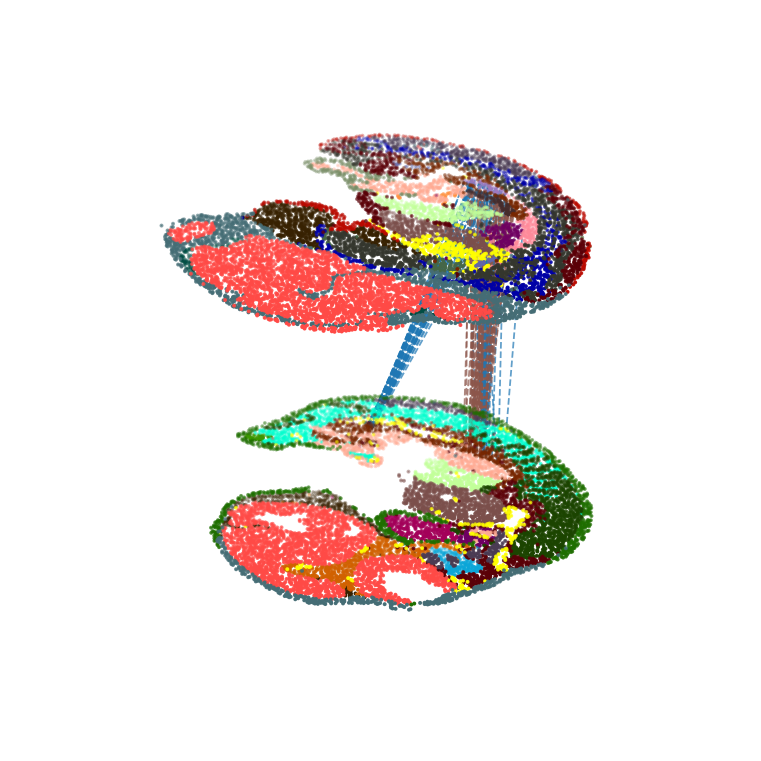

In [14]:
kidney_align = match_3D_celltype(adata1_df, adata2_df, matching, meta='celltype', 
                                 highlight_celltype = [['Urogenital ridge'],['Kidney','Ovary']],
                                 subsample_size=10000, highlight_line = ['blue'], scale_coordinate = True )
kidney_align.draw_3D(size= [6, 6], line_width =0.8, point_size=[0.6,0.6], hide_axis=True)

We can get the lineage of the query's cells and mappings using the following function

In [15]:
def cal_matching_cell(target_adata,query_adata,matching,query_cell,clusters='annotation',):
    adata1_df = pd.DataFrame({'index':range(target_adata.shape[0]),
                          'x': target_adata.obsm['spatial'][:,0],
                          'y': target_adata.obsm['spatial'][:,1],
                          'celltype':target_adata.obs[clusters]})
    adata2_df = pd.DataFrame({'index':range(query_adata.shape[0]),
                              'x': query_adata.obsm['spatial'][:,0],
                              'y': query_adata.obsm['spatial'][:,1],
                              'celltype':query_adata.obs[clusters]})
    query_adata = target_adata[matching[1,adata2_df.loc[adata2_df.celltype==query_cell,'index'].values],:]
    #adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
    #adata2_df['target_obs_names'] = adata1_df.iloc[matching[1,:],:].index.to_list()
    
    #query_obs=adata2_df.loc[adata2_df['celltype']==query_cell,'target_obs_names'].tolist()
    return query_adata
    


We find that maps mapped on 3D also show up well on 2D

In [21]:
query_adata=cal_matching_cell(target_adata=adata1,
                              query_adata=adata2,
                              matching=matching,
                              query_cell='Kidney',clusters='annotation')
query_adata

View of AnnData object with n_obs × n_vars = 59 × 26854
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - A1cf', 'kidney_c0', 'kidney_c1', 'kidney_c2', 'kidney_c3', 'kidney_anno', 'week'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Spatial_Net', 'annotation_colors', 'kidney_c0_colors', 'kidney_c1_colors', 'kidney_c2_colors', 'kidney_c3_colors', 'kidney_anno_colors'
    obsm: 'spatial'
    varm: 'PCs'

In [17]:
adata1.obs['kidney_anno']=''
adata1.obs.loc[query_adata.obs.index,'kidney_anno']=query_adata.obs['annotation']

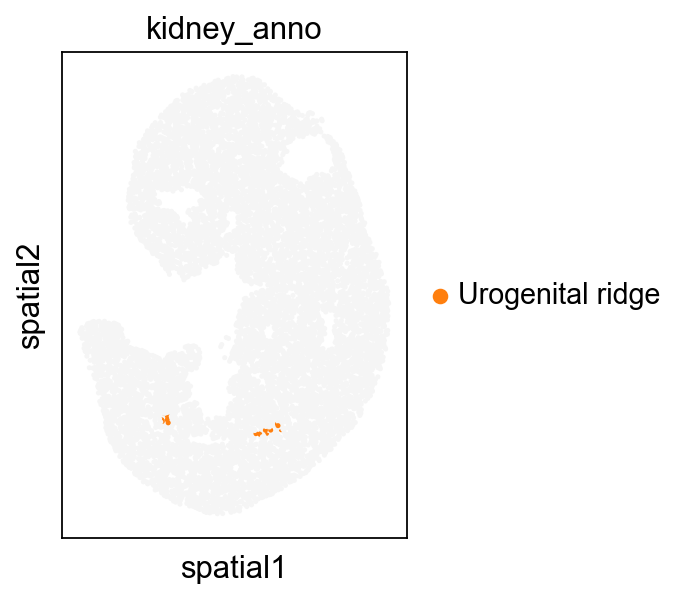

In [18]:
sc.pl.spatial(adata1, color='kidney_anno', spot_size=3,
             palette=['#F5F5F5','#ff7f0e', 'green',])

We are concerned with Kidney lineage development, so we integrated the cells corresponding to the Kidney lineage on the two sections of E11 and E12, and then we could use the method of difference analysis to study the dynamic process of Kidney lineage development.

In [22]:
kidney_lineage_ad=sc.concat([query_adata,adata2[adata2.obs['annotation']=='Kidney']],merge='same')
kidney_lineage_ad=ov.pp.preprocess(kidney_lineage_ad,mode='shiftlog|pearson',n_HVGs=3000,target_sum=1e4)
kidney_lineage_ad.raw = kidney_lineage_ad
kidney_lineage_ad = kidney_lineage_ad[:, kidney_lineage_ad.var.highly_variable_features]
ov.pp.scale(kidney_lineage_ad)
ov.pp.pca(kidney_lineage_ad)
ov.pp.neighbors(kidney_lineage_ad,use_rep='scaled|original|X_pca',metric="cosine")
ov.utils.cluster(kidney_lineage_ad,method='leiden',resolution=1)
ov.pp.umap(kidney_lineage_ad)

Begin robust gene identification
After filtration, 14823/26436 genes are kept. Among 14823 genes, 14823 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 0.07181000709533691 seconds.
End of size normalization: shiftlog and HVGs selection pearson
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing neighbors


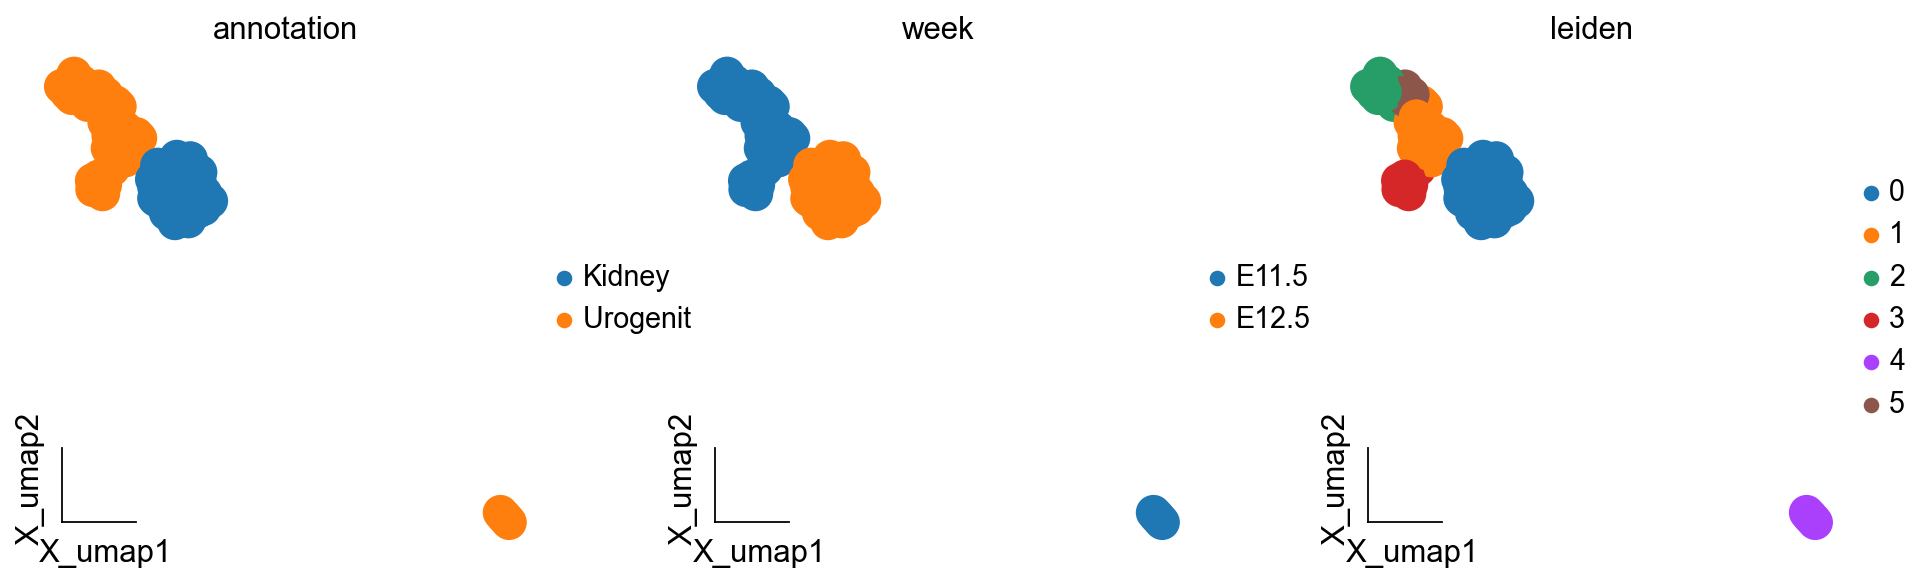

In [23]:
ov.pl.embedding(kidney_lineage_ad,basis='X_umap',
               color=['annotation','week','leiden'],
               frameon='small')

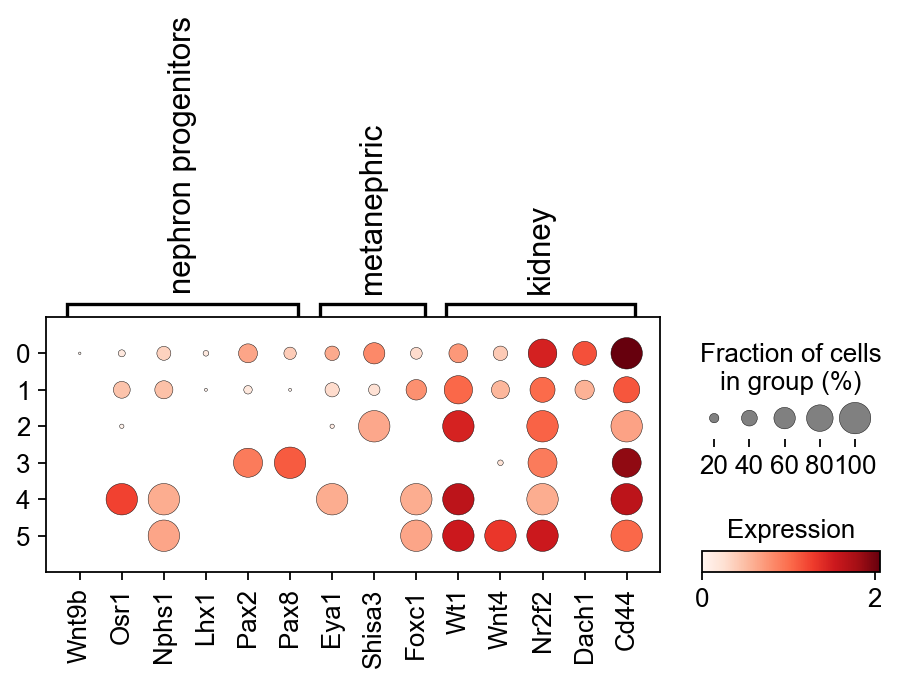

In [25]:
# Nphs1 https://www.nature.com/articles/s41467-021-22266-1
sc.pl.dotplot(kidney_lineage_ad,{'nephron progenitors':['Wnt9b','Osr1','Nphs1','Lhx1','Pax2','Pax8'],
                         'metanephric':['Eya1','Shisa3','Foxc1'], 
                         'kidney':['Wt1','Wnt4','Nr2f2','Dach1','Cd44']} ,
              'leiden',dendrogram=False,colorbar_title='Expression')

In [26]:
kidney_lineage_ad.obs['re_anno'] = 'Unknown'
kidney_lineage_ad.obs.loc[kidney_lineage_ad.obs.leiden.isin(['4']),'re_anno'] = 'Nephron progenitors (E11.5)'
kidney_lineage_ad.obs.loc[kidney_lineage_ad.obs.leiden.isin(['2','3','1','5']),'re_anno'] = 'Metanephron progenitors (E11.5)'
kidney_lineage_ad.obs.loc[kidney_lineage_ad.obs.leiden=='0','re_anno'] = 'Kidney (E12.5)'

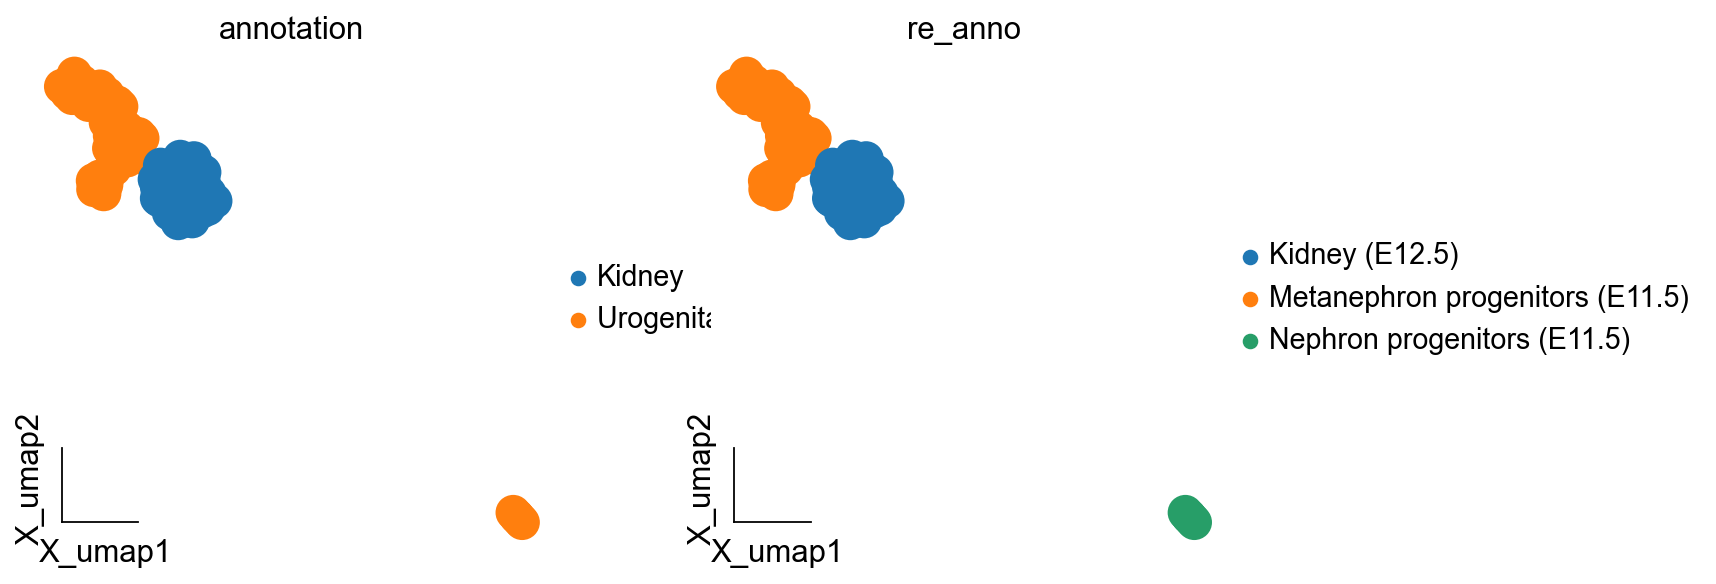

In [28]:
# kidney_all = kidney_all[kidney_all.obs.leiden!='3',:]
kidney_lineage_ad.obs.leiden = list(kidney_lineage_ad.obs.leiden)
ov.pl.embedding(kidney_lineage_ad,basis='X_umap',
               color=['annotation','re_anno'],
               frameon='small')

In [29]:
adata1.obs['kidney_anno']=''
adata1.obs.loc[kidney_lineage_ad[kidney_lineage_ad.obs['week']=='E11.5'].obs.index,'kidney_anno']=kidney_lineage_ad[kidney_lineage_ad.obs['week']=='E11.5'].obs['re_anno']

[<AxesSubplot: title={'center': 'kidney_anno'}, xlabel='spatial1', ylabel='spatial2'>]

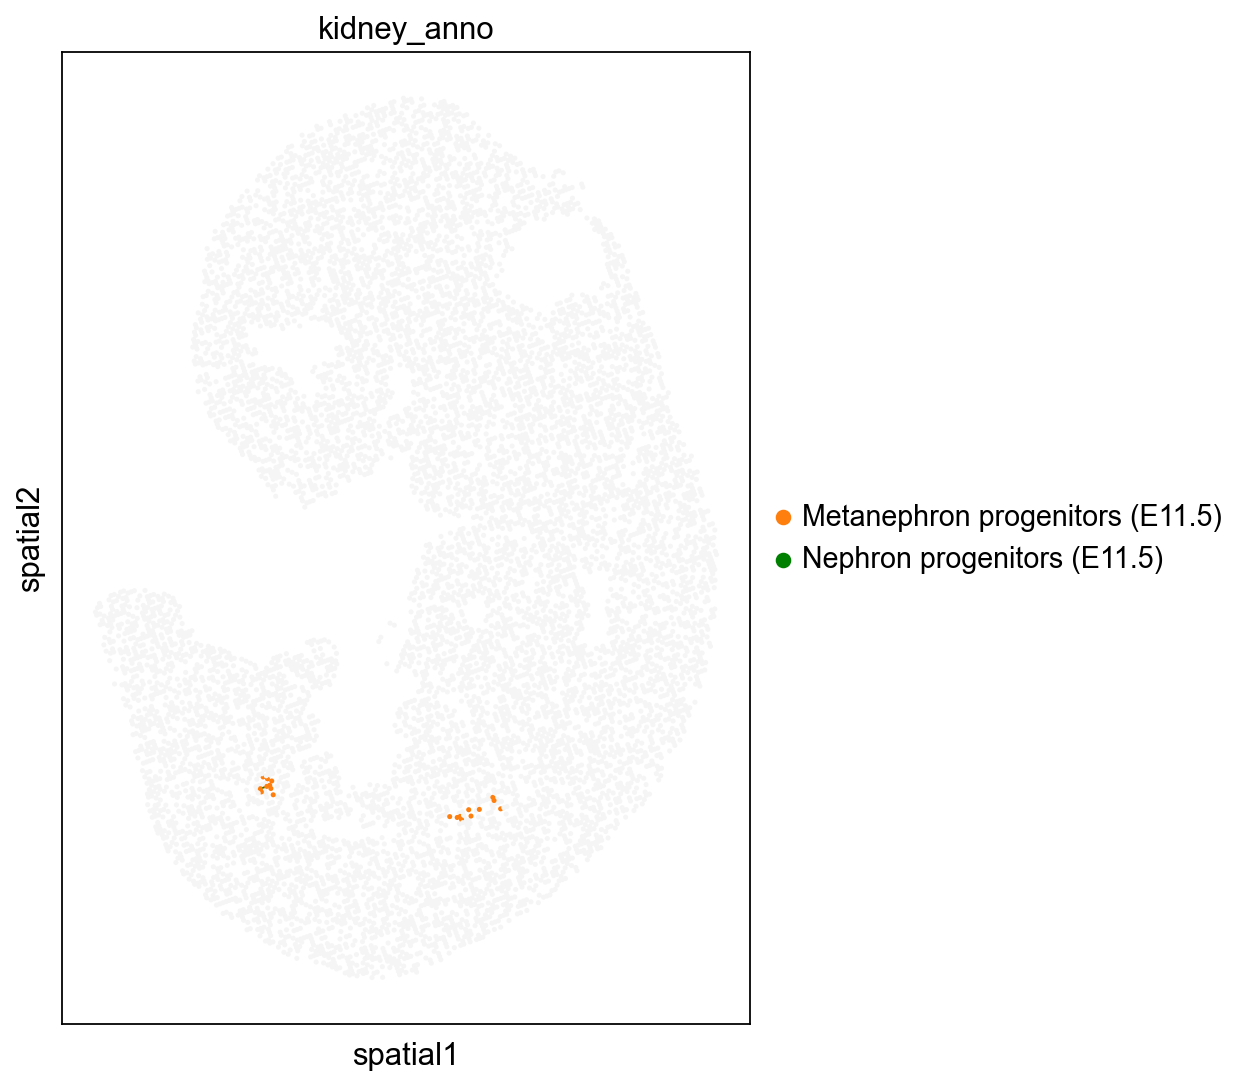

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sc.pl.spatial(adata1, color='kidney_anno', spot_size=1.5,
             palette=['#F5F5F5','#ff7f0e', 'green',],show=False,ax=ax)

We can also differentially analyse Kidney's developmental pedigree to find different marker genes, and we can analyse transcription factors and thus find the regulatory units involved.

In [42]:
test_adata=kidney_lineage_ad
dds=ov.bulk.pyDEG(test_adata.to_df(layer='lognorm').T)
dds.drop_duplicates_index()
print('... drop_duplicates_index success')
treatment_groups=test_adata.obs[test_adata.obs['week']=='E12.5'].index.tolist()
control_groups=test_adata.obs[test_adata.obs['week']=='E11.5'].index.tolist()
result=dds.deg_analysis(treatment_groups,control_groups,method='ttest')
# -1 means automatically calculates
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

... drop_duplicates_index success
... Fold change threshold: 2.1686935424804688


<AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

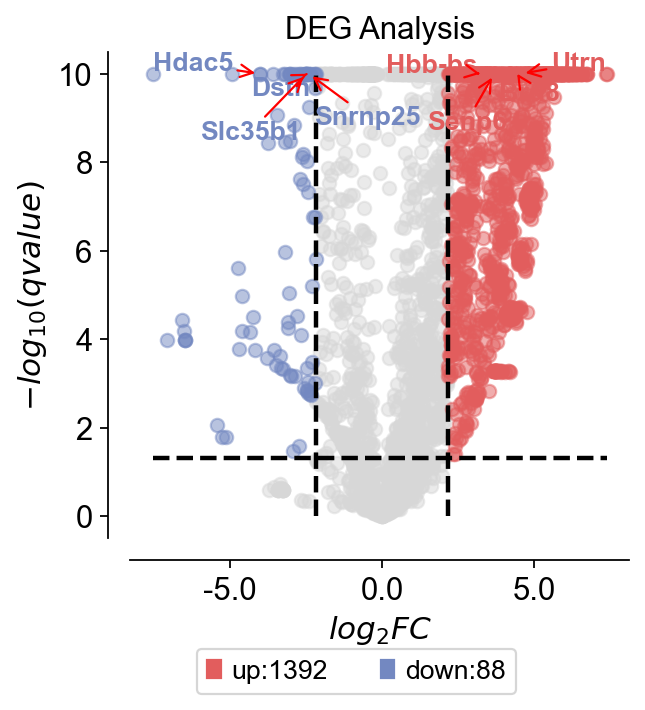

In [43]:
dds.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

In [52]:
up_gene=dds.result.loc[dds.result['sig']=='up'].sort_values('qvalue')[:3].index.tolist()
down_gene=dds.result.loc[dds.result['sig']=='down'].sort_values('qvalue')[:3].index.tolist()
deg_gene=up_gene+down_gene

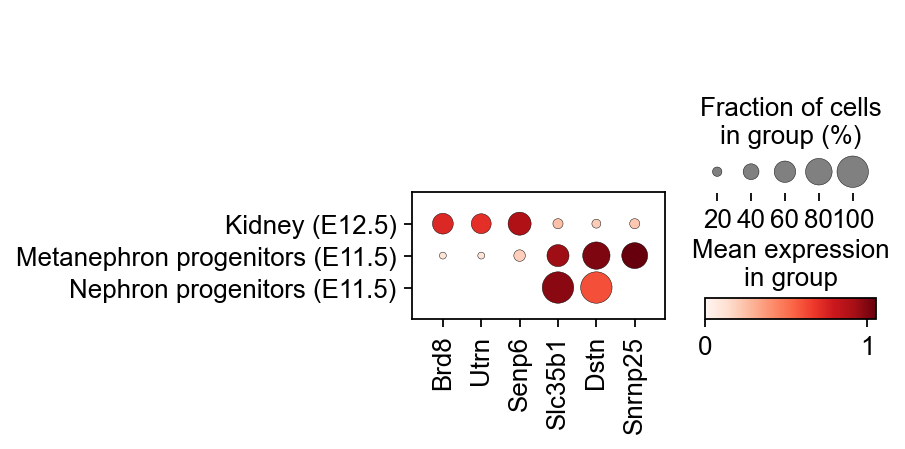

In [53]:
sc.pl.dotplot(kidney_lineage_ad,deg_gene,
             groupby='re_anno')

In addition to analysing directly using differential expression, we can also look for weekly marker genes by considering weeks as categories.

Storing dendrogram info using `.uns['dendrogram_re_anno']`
ranking genes
    finished: added to `.uns['re_anno_ttest']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


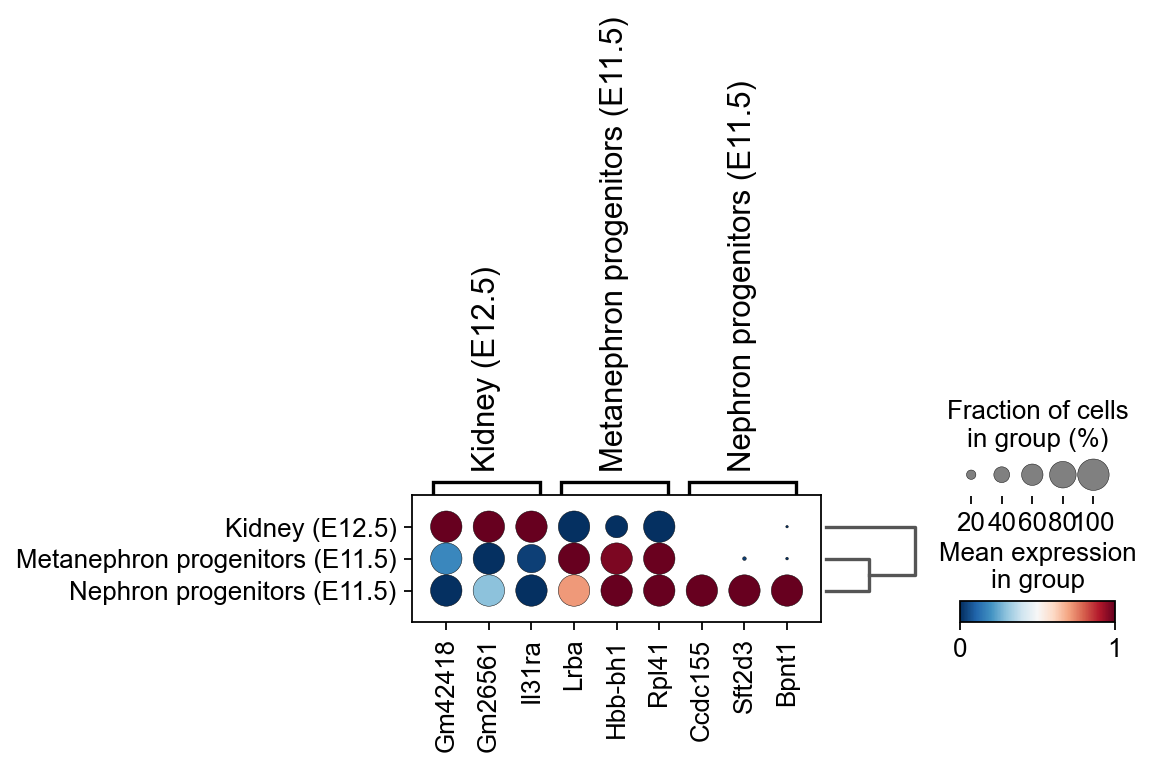

In [55]:
sc.tl.dendrogram(kidney_lineage_ad,'re_anno',use_rep='scaled|original|X_pca')
sc.tl.rank_genes_groups(kidney_lineage_ad, 're_anno', use_rep='scaled|original|X_pca',
                        method='t-test',use_raw=False,key_added='re_anno_ttest')
sc.pl.rank_genes_groups_dotplot(kidney_lineage_ad,groupby='re_anno',
                                cmap='RdBu_r',key='re_anno_ttest',
                                standard_scale='var',n_genes=3)